This script runs Kleinberg's burst detection algorithm on simulated data to validate the method.

In [2]:
import pandas as pd
import numpy as np
import burst_detection as bd

import matplotlib.pyplot as plt  
import seaborn as sns
from matplotlib import rcParams
%pylab inline 

#set plot properties
sns.set_style("white")
rcParams['font.size'] = 12

Populating the interactive namespace from numpy and matplotlib


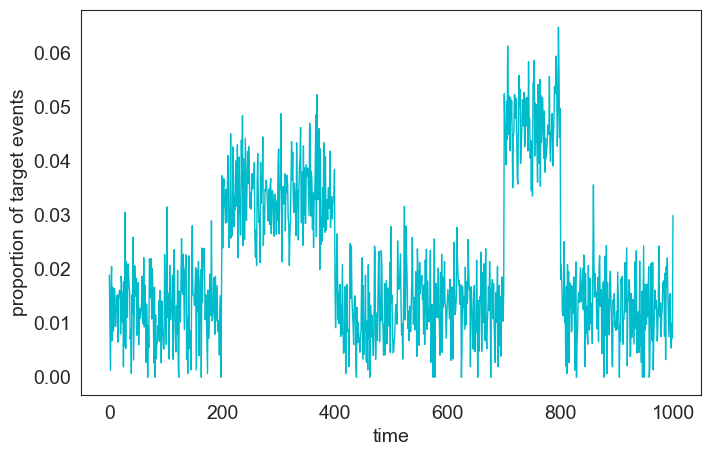

In [3]:
#simulate the baseline data
timepoints = 1000
d = pd.Series(np.floor(np.ones(timepoints)*1500 + np.random.normal(scale=40, size=timepoints))) #total events
r = pd.Series(np.floor(np.ones(timepoints)*20 + np.random.normal(scale=10, size=timepoints)))   #target events
r[r<0] = 0 #set negative values to 0

#add some bursts
r[200:400] = r[200:400] + 30 #+ np.random.normal(scale=10, size=200)
r[700:800] = r[700:800] + 50 #+ np.random.normal(scale=10, size=100)

org_r = r

plt.subplots(figsize=(8, 5))
plt.plot(org_r/d, color='#00bbcc', linewidth=1)
plt.yticks(size=14);
plt.xticks(size=14);
plt.ylabel('proportion of target events', size=14)
plt.xlabel('time', size=14)
plt.savefig("raw_timeseries.jpg", bbox_inches="tight", dpi=600)

In [4]:
d

0      1484.0
1      1531.0
2      1543.0
3      1425.0
4      1466.0
        ...  
995    1501.0
996    1485.0
997    1503.0
998    1518.0
999    1506.0
Length: 1000, dtype: float64

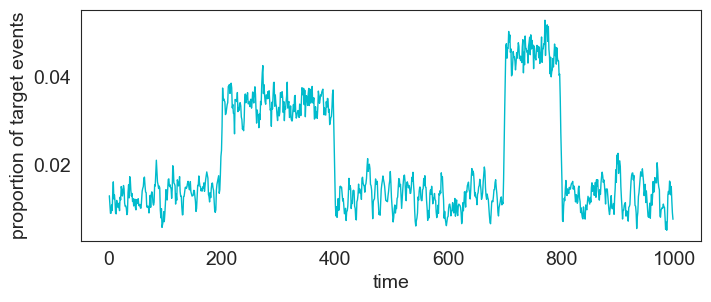

In [4]:
x = org_r.rolling(window=5, center=True).mean()
plt.subplots(figsize=(8, 3))
plt.plot(x/d, color='#00bbcc', linewidth=1)
plt.yticks(size=14);
plt.xticks(size=14);
plt.ylabel('proportion of target events', size=14)
plt.xlabel('time', size=14)
plt.savefig("smooth5_timeseries.jpg", bbox_inches="tight", dpi=600)

Notes: Temporal smoothing seems to greatly improve the ability of the algorithm to identify bursts. It makes the interpretation of the burst endpoints tricky though. N is equal to the number of non-nan elements in r.

In [5]:
#create a timeline of the bursts
def plot_burst_timeline(bursts, timepoints, label):
    
    f, ax = plt.subplots(figsize=(8, 0.5))
    ax.set(xlim=(0, timepoints), ylabel="", xlabel="")

    #create boxes around bursting periods
    for index, burst in bursts.iterrows():

        #define outline positions
        y = 0.25
        xstart = burst['begin'] -1 
        width = burst['end'] - burst['begin'] +1

        #draw rectangle
        ax.add_patch(Rectangle((xstart,y), width, height=0.5, 
                               facecolor='#00bbcc', edgecolor='none', linewidth=1))

    #remove borders
    ax.xaxis.set_visible(False)
    plt.yticks([0.5], [label], size=14)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    #add a timeline
    plt.axhline(0.5, linewidth=1, color='k', alpha=1, zorder=0.5)

    plt.show()

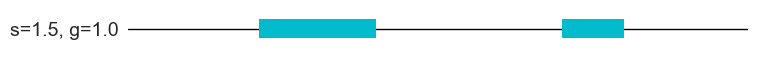

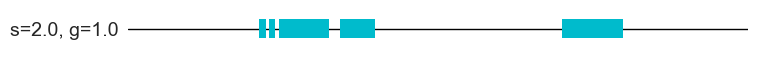

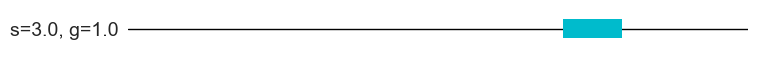

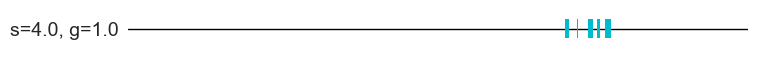

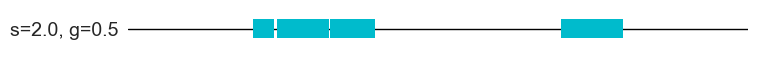

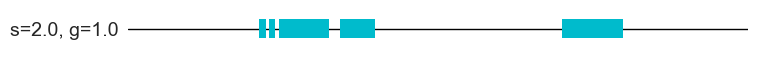

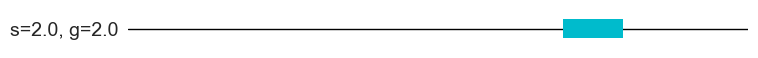

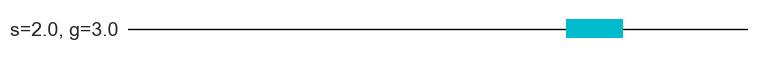

In [6]:
#find bursts

#define variables
n = len(r)    #number of timepoints
k = 2         #number of states

#col 0: s -- resolution of state jumps; higher s --> bigger jumps between states
#col 1: gamma -- difficulty of moving up a state; larger gamma --> harder to move up states
variables = [[1.5, 1.0],
             [2.0, 1.0],
             [3.0, 1.0],
             [4.0, 1.0],
             [2.0, 0.5],
             [2.0, 1.0],
             [2.0, 2.0],
             [2.0, 3.0]]

for v in variables:

    #find the optimal state sequence (using the Viterbi algorithm)
    [q, _, _, p] = bd.burst_detection(r,d,n,v[0],v[1],smooth_win=5)

    #create label
    label = 's='+str(v[0])+', g='+str(v[1])

    #enumerate the bursts
    bursts = bd.enumerate_bursts(q, label)

    #find weight of each burst
    bursts = bd.burst_weights(bursts, r, d, p)
    
    #plot the optimal state sequence
    plot_burst_timeline(bursts, timepoints, label)
